In [1]:
import implicit
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import coo_matrix

In [2]:
from kaggle_hm.evaluation import compute_precision, enrich_data, precision_by_age, plot_precision_at_k_segments, plot_precision_at_k, precision_by_usage
from kaggle_hm.utils import visualize_items

In [3]:
from kaggle_hm.config import data_root, train_dates, test_dates
from kaggle_hm.chart_model import filter_data

In [4]:
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')
c = pd.read_parquet(data_root / 'clean' / 'customers.parquet').set_index('customer_id')
c['age_group'] = pd.cut(c['age'], bins=[16, 21, 25, 30, 40, 50, 60, 100])

In [5]:
class Transformer:
    def __init__(self) -> None:
        self.item_code = {}
        self.code_item = {}
    
    def fit(self, ids):
        self.item_code = {item_id: code for code, item_id in enumerate(ids)}
        self.code_item = {v: k for k, v in self.item_code.items()}
    
    def transform(self, ids):
        return [self.item_code[_] for _ in ids]
    
    def inverse(self, codes):
        return [self.code_item[_] for _ in codes]

In [6]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [9]:
train = filter_data(df, '2020-09-01', train_dates['end'])
test = filter_data(df, test_dates['start'], test_dates['end'])
big_train = filter_data(df, to_date='2020-09-08')

results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set))
test_nodup = test.drop_duplicates(subset=['customer_id', 'article_id'])
cols = [f'rel_{i + 1}' for i in range(12)]

In [27]:
i_stats = train.groupby('article_id').agg(cust_total=('customer_id', 'count')).query('cust_total >= 1').reset_index()

_ = (
    train['article_id'].isin(set(i_stats['article_id']))
) #?

c_stats = train[_].groupby('customer_id').agg(items_total=('article_id', 'count')).query('items_total >= 1').reset_index()
print('customers', c_stats.shape)
print('items', i_stats.shape)

customers (85300, 2)
items (20149, 2)


In [28]:
_ = (
    train['customer_id'].isin(set(c_stats['customer_id'])) &
    train['article_id'].isin(set(i_stats['article_id']))
)

pairs = train[_][['customer_id', 'article_id']].drop_duplicates()

item_transformer = Transformer()
item_transformer.fit(pairs['article_id'].unique())

cust_transformer = Transformer()
cust_transformer.fit(pairs['customer_id'].unique())

data = np.ones(pairs.shape[0])
ptrs = (cust_transformer.transform(pairs['customer_id']), item_transformer.transform(pairs['article_id']))
X = coo_matrix((data, ptrs)).tocsr()

# todo tdidf
# todo 1/days since buy
X

<85300x20149 sparse matrix of type '<class 'numpy.float64'>'
	with 271931 stored elements in Compressed Sparse Row format>

In [98]:
# filter users with X interactions
# filter items with at least Y interactions

In [39]:
model = implicit.als.AlternatingLeastSquares(factors=500, regularization=0.01, iterations=5, calculate_training_loss=True, use_gpu=True)
model.fit(X)

  0%|          | 0/5 [00:00<?, ?it/s]

In [40]:
_ = (
    train['article_id'].isin(item_transformer.item_code.keys())
)

pairs = train[_][['customer_id', 'article_id']].drop_duplicates()

cust_transformer = Transformer()
cust_transformer.fit(pairs['customer_id'].unique())

data = np.ones(pairs.shape[0])
ptrs = (cust_transformer.transform(pairs['customer_id']), item_transformer.transform(pairs['article_id']))
X = coo_matrix((data, ptrs)).tocsr()

X

<85300x20149 sparse matrix of type '<class 'numpy.float64'>'
	with 271931 stored elements in Compressed Sparse Row format>

In [41]:
items, scores = model.recommend(np.arange(X.shape[0]), X, N=12, filter_already_liked_items=True, recalculate_user=True)
rec_df = pd.DataFrame(items)
rec_cols = np.arange(12)
rec_df['candidates'] = rec_df[rec_cols].apply(lambda item_list: item_transformer.inverse(item_list), axis=1)
rec_df['customer_id'] = cust_transformer.inverse(rec_df.index)
als_pred = rec_df.set_index('customer_id')['candidates'].explode().reset_index()
als_pred['r'] = als_pred.groupby('customer_id').cumcount()

In [28]:
from typing import List


def pad_rec(recommended: List, top_items):
    try:
        if np.isnan(recommended):
            recommended = []
    except:
        pass
    n = len(recommended)
    if n >= 12:
        return recommended
    while n < 12:
        if top_items[0] not in recommended:
            recommended.append(top_items[0])
        top_items.pop(0)
        n = len(recommended)
    return recommended

top12 = (
    train
    .groupby('article_id')
    .agg(total_count=('customer_id', 'count'))
    .sort_values('total_count', ascending=False).reset_index()[:24]['article_id'].tolist()
)

In [42]:
comb = results.merge(rec_df, left_index=True, right_on='customer_id')
comb['prediction'] = comb['candidates']
comb = compute_precision(comb)
comb = enrich_data(filter_data(df, to_date='2020-09-08'), comb.set_index('customer_id'), c)
comb['precision'].mean()

0.01164845732247315

In [46]:
comb.shape

(15286, 34)

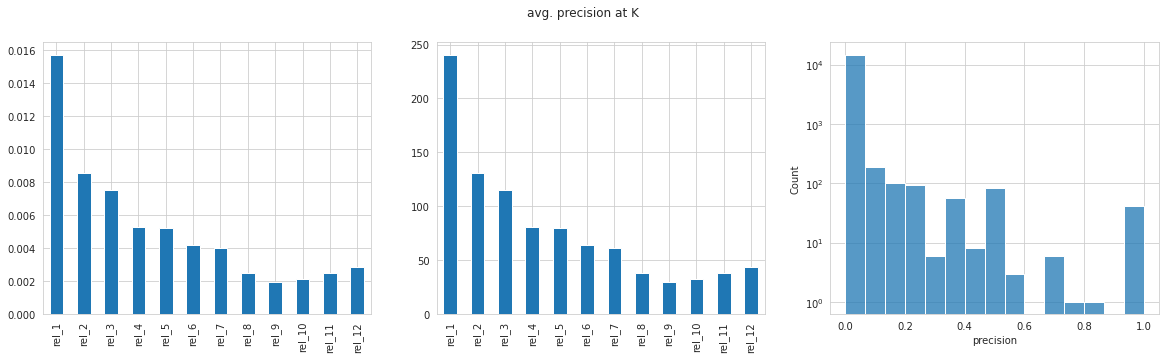

In [44]:
plot_precision_at_k(comb);

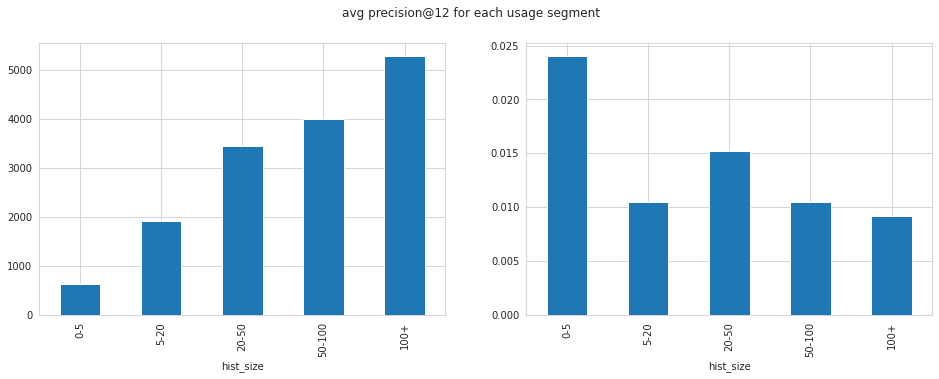

In [45]:
precision_by_usage(comb);

In [39]:
comb[cols].sum()

rel_1     547
rel_2     420
rel_3     341
rel_4     285
rel_5     304
rel_6     273
rel_7     282
rel_8     260
rel_9     239
rel_10    211
rel_11    201
rel_12    210
dtype: int64

In [29]:
comb = results.merge(rec_df, left_index=True, right_on='customer_id', how='left')
comb['prediction'] = comb['candidates']
f = comb['prediction'].isna()
comb.loc[f, 'prediction'] = comb.loc[f, 'prediction'].apply(lambda _: top12[:12])
comb = compute_precision(comb)
comb['precision'].mean()

0.007678937273851696

In [426]:
min_cust = 25
min_items = 10

c_stats = train.groupby('customer_id').agg(items_total=('article_id', 'count')).query(f'items_total >= {min_items}').reset_index()
i_stats = train.groupby('article_id').agg(cust_total=('customer_id', 'count')).query(f'cust_total >= {min_cust}').reset_index()

def eval_model(train_data, items: set, customers: set, factors=32, iterations=10, reg=0.01):
    _ = (
        train_data['customer_id'].isin(customers) &
        train_data['article_id'].isin(items)
    )

    pairs = train_data[_][['customer_id', 'article_id']].drop_duplicates()

    item_transformer = Transformer()
    item_transformer.fit(pairs['article_id'].unique())

    cust_transformer = Transformer()
    cust_transformer.fit(pairs['customer_id'].unique())

    data = np.ones(pairs.shape[0])
    ptrs = (cust_transformer.transform(pairs['customer_id']), item_transformer.transform(pairs['article_id']))
    X = coo_matrix((data, ptrs)).tocsr()

    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=reg, iterations=iterations, calculate_training_loss=True, use_gpu=True, num_threads=4)
    model.fit(X)

    _ = (
        train_data['article_id'].isin(items)
    )
    pairs = train_data[_][['customer_id', 'article_id']].drop_duplicates()
    cust_transformer = Transformer()
    cust_transformer.fit(pairs['customer_id'].unique())

    data = np.ones(pairs.shape[0])
    ptrs = (cust_transformer.transform(pairs['customer_id']), item_transformer.transform(pairs['article_id']))
    X = coo_matrix((data, ptrs)).tocsr()

    items, scores = model.recommend(np.arange(X.shape[0]), X, N=12, filter_already_liked_items=True, recalculate_user=True)

    rec_df = pd.DataFrame(items)
    rec_cols = np.arange(12)
    rec_df['candidates'] = rec_df[rec_cols].apply(lambda item_list: item_transformer.inverse(item_list), axis=1)
    rec_df['customer_id'] = cust_transformer.inverse(rec_df.index)

    comb = results.merge(rec_df, left_index=True, right_on='customer_id')
    comb['prediction'] = comb['candidates']
    comb = compute_precision(comb)

    return comb['precision'].mean()

In [429]:
item_whitelist = set(i_stats['article_id'])
customer_whitelist = set(c_stats['customer_id'])

In [ ]:
factors = [32, 64, 128, 256]
iters = [10, 20, 50, 100]
reg = [0.01, 0.1, 1, 10, 100]

t_results = []

for f in factors:
    for i in iters:
        for r in reg:
            _ = {
                'factors': f,
                'iters': i,
                'regularizetion': r,
                'precision': eval_model(train, item_whitelist, customer_whitelist, factors=f, iterations=i, reg=r)
            }
            t_results.append(_)

In [444]:
res_df = pd.DataFrame(t_results)

In [447]:
res_df.to_csv(data_root / 'output' / 'als_comparison.csv', index=False)

In [14]:
pd.read_csv(data_root / 'output' / 'als_comparison.csv').sort_values('precision', ascending=False)

,factors,iters,regularizetion,precision
63,256,10,10.0,0.010931
68,256,20,10.0,0.010729
78,256,100,10.0,0.010693
73,256,50,10.0,0.010681
43,128,10,10.0,0.010197
...,...,...,...,...
74,256,50,100.0,0.000100
59,128,100,100.0,0.000100
54,128,50,100.0,0.000100
34,64,50,100.0,0.000100


In [305]:
pd.DataFrame({
    'total': comb[cols].mean(),
    'total-s': comb[cols].sum(),
})

,total,total-s
rel_1,0.008178,589
rel_2,0.005207,375
rel_3,0.006137,442
rel_4,0.002013,145
rel_5,0.004596,331
rel_6,0.003638,262
rel_7,0.003805,274
rel_8,0.002472,178
rel_9,0.004763,343
rel_10,0.003555,256


<AxesSubplot:xlabel='candidates', ylabel='Count'>

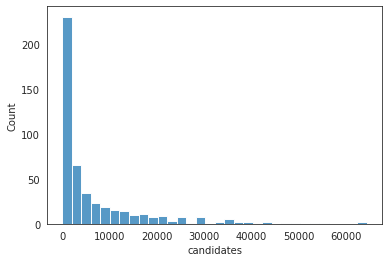

In [94]:
sns.histplot(als_pred['candidates'].value_counts())

In [ ]:
# scores exploration

In [177]:
_ = test_nodup.merge(als_pred, left_on=['customer_id', 'article_id'], right_on=['customer_id', 'candidates'])

In [178]:
_.shape

(2124, 7)

In [179]:
_.head()

,t_dat,customer_id,article_id,price,sales_channel_id,candidates,r
0,2020-09-09,00de88beb1f4cbe4085646ee9cdd94d2dffd4c00eae555...,0921226004,0.016932,2,0921226004,1
1,2020-09-09,01b9cc832b89259e841145249ca7f91e946714ef7fbe8b...,0921906001,0.033881,1,0921906001,11
2,2020-09-09,01b9cc832b89259e841145249ca7f91e946714ef7fbe8b...,0918892001,0.033881,1,0918892001,1
3,2020-09-09,03fc16f68cface090afdaea5702f1f9a92cad5073d4df9...,0759814009,0.033881,2,0759814009,4
4,2020-09-09,046ce89046b4144bdb0ed60ed206e3863cbc4eed61ef4a...,0914441001,0.033881,2,0914441001,10


In [180]:
_['r'].value_counts().sort_index()

0     372
1     260
2     229
3     179
4     169
5     178
6     123
7     137
8     115
9     121
10    124
11    117
Name: r, dtype: int64

In [ ]:
sales = (
    train.groupby('article_id').agg(total_sold=('customer_id', 'count')).reset_index()
)
sales.sort_values('total_sold', ascending=False).head(15)
cid = '0896152002'
ids, scores = model.similar_items(item_transformer.item_code[cid], N=20)

visualize_items(item_transformer.inverse(ids));

In [104]:
test_customers = np.array(cust_transformer.transform(results.index))
items, scores = model.recommend(test_customers, X[test_customers], N=12, filter_already_liked_items=True, recalculate_user=False)
rec_df = pd.DataFrame(items, index=results.index)
rec_cols = np.arange(12)
rec_df['candidates'] = rec_df[rec_cols].apply(lambda item_list: item_transformer.inverse(item_list), axis=1)
results = results.join(rec_df)
results['prediction'] = results['candidates']

In [105]:
results = compute_precision(results)
results.head()

,bought,0,1,2,3,4,5,6,7,8,...,rel_5,rel_6,rel_7,rel_8,rel_9,rel_10,rel_11,rel_12,rel_total,precision
customer_id,,,,,,,,,,,,,,,,,,,,,
000fa1b80857fa40bf25990bc1b1b65afc63923a8e4b5762db34e4bb46032d29,"{0801673002, 0748355018, 0879291001, 075803400...",5971,641,639,4766,1958,2039,11095,2506,21217,...,0,0,0,0,0,0,0,0,0,0.0
00125440be6cd148c3599b9c5a2d55f5838c1b0257d35643038c38a60c691fe8,"{0723469002, 0882882010, 0610776105, 082796802...",600,4262,22523,1382,1433,5971,6575,7402,22295,...,0,0,0,0,0,0,0,0,0,0.0
0015f16aa2702e2ec13d2e38052f496b9b915d3c64e82cdb9ce11b9324c32b34,"{0865929007, 0751471038}",969,173,1697,1239,1753,197,1958,708,3704,...,0,0,0,0,0,0,0,0,0,0.0
001cae0f8d784913b4850af09f2c86ce09cdd177f49f8859ef373cebfd8d1594,{0710695015},218,4204,19386,17888,3168,135,2078,459,17910,...,0,0,0,0,0,0,0,0,0,0.0
0036a44bd648ce2dbc32688a465b9628b7a78395302f26dd57b4ed75dce9b70c,"{0714790020, 0714790008, 0835348006}",16,2367,600,2373,22270,23627,641,1042,496,...,0,0,0,0,0,0,0,0,0,0.0


In [106]:
results['precision'].mean()

0.005815882741824916

In [55]:
row = results.sample(n=1).iloc[0]

train_items = train[train['customer_id'] == row.name]

In [114]:
train['article_id'].value_counts()[:12]

0706016001    4744
0751471001    4540
0372860002    3759
0610776002    3696
0730683050    3507
0760084003    3230
0372860001    2953
0448509014    2912
0783346001    2890
0827968001    2838
0610776001    2823
0464297007    2780
Name: article_id, dtype: int64

In [117]:
results['prediction'].explode().value_counts()[:12]

0768912001    8076
0547780003    5285
0739819010    5273
0915526001    4929
0610776068    4901
0751471043    4582
0812668001    4558
0762846006    4489
0749699002    4465
0758034001    4167
0610776071    4099
0915529003    3954
Name: prediction, dtype: int64

In [119]:
df.tail()

,t_dat,customer_id,article_id,price,sales_channel_id
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1
31788323,2020-09-22,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,0898573003,0.033881,2


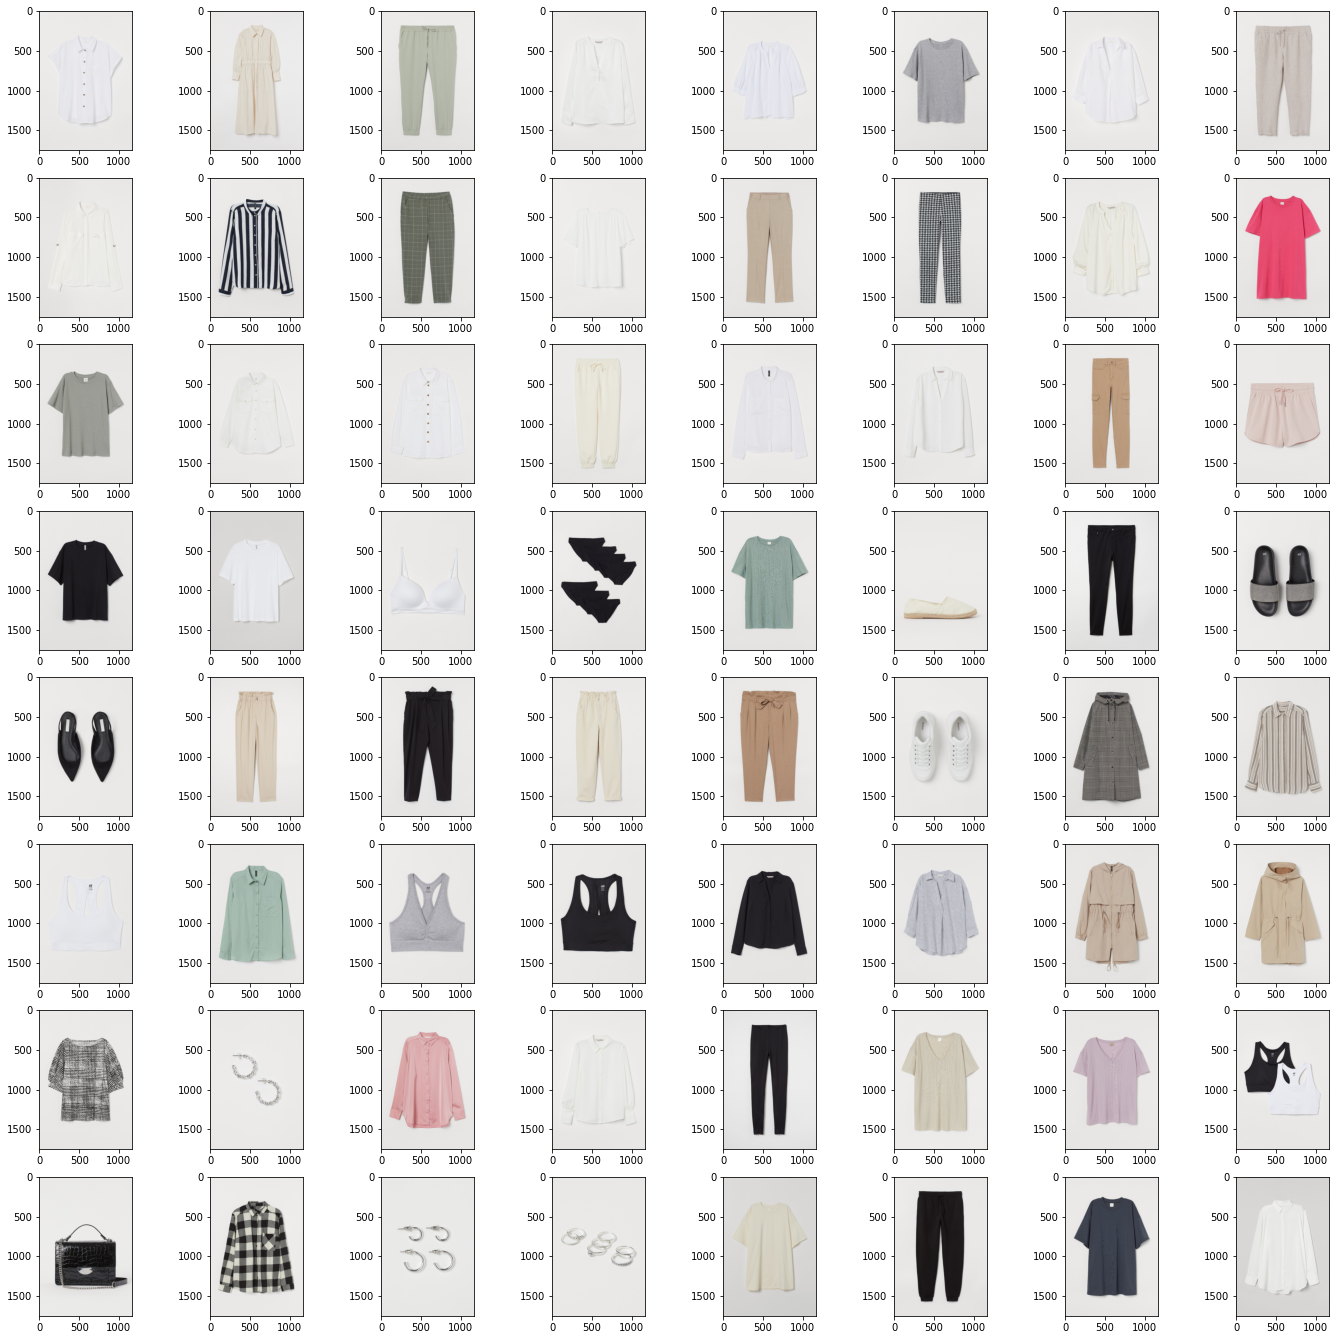

In [58]:
visualize_items(train_items['article_id'].unique())

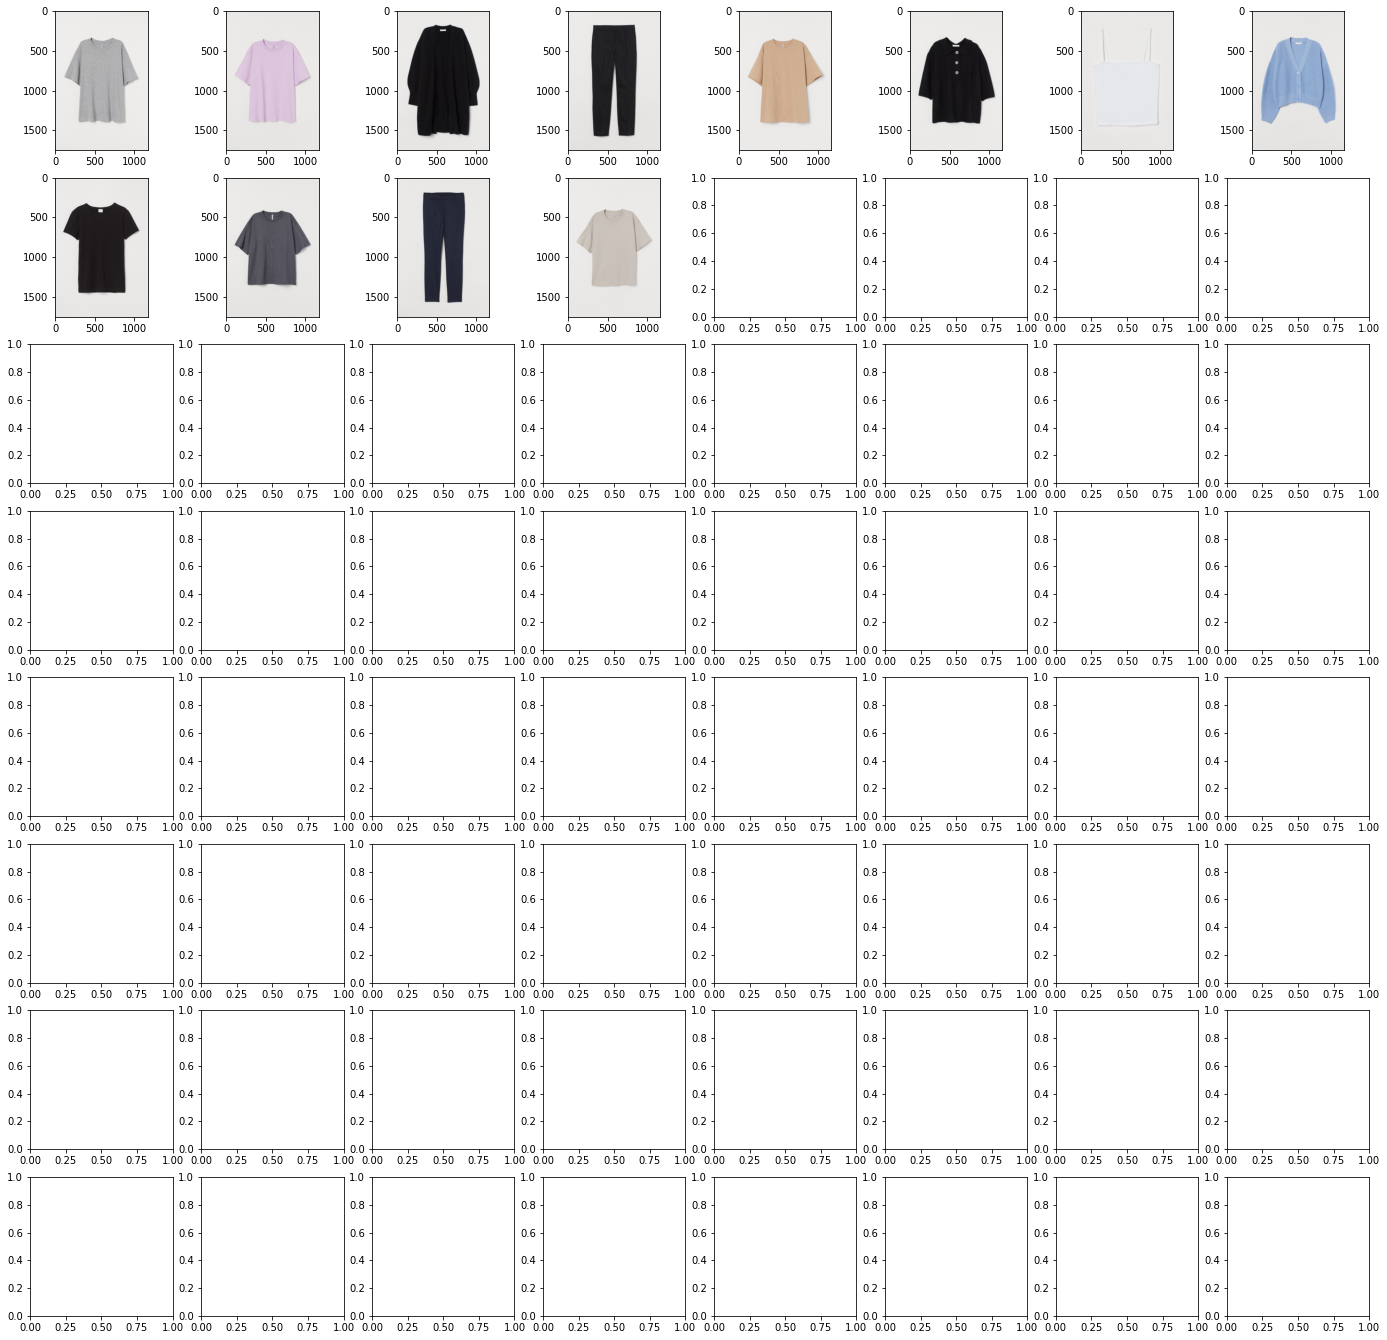

In [59]:
visualize_items(list(row['prediction']))

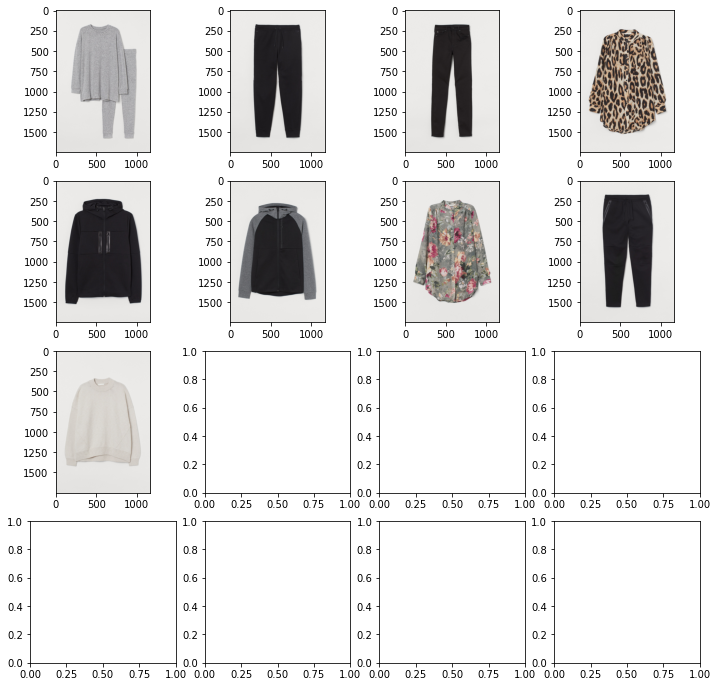

In [60]:
visualize_items(list(row['bought']), 4, 4)

In [10]:
trends = train.groupby('article_id', observed=True).agg(min_dt=('t_dat', 'min'), max_dt=('t_dat', 'max'))

In [11]:
trends.shape

(102967, 2)

<AxesSubplot:>

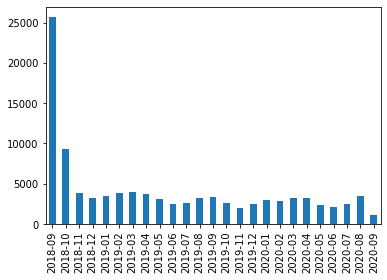

In [10]:
trends['min_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

<AxesSubplot:>

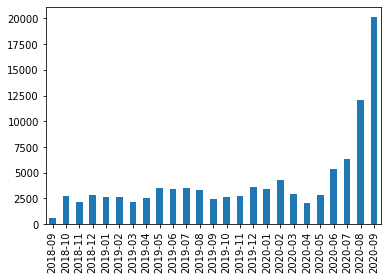

In [115]:
trends['max_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

<AxesSubplot:>

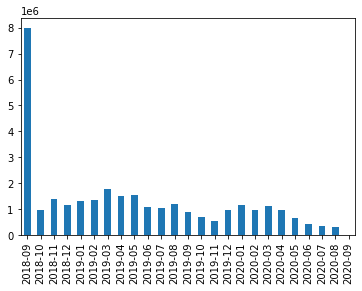

In [12]:
train.merge(trends, left_on='article_id', right_index=True, how='left')['min_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

<AxesSubplot:>

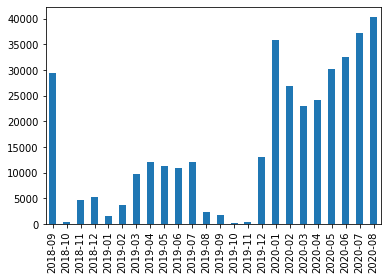

In [120]:
_ = results['prediction'].explode().reset_index().merge(trends, left_on='prediction', right_index=True, how='left')
(_['min_dt'].dt.to_period('m').value_counts().sort_index()).plot.bar()

In [108]:
train_dates

{'start': '2020-07-01', 'end': '2020-09-08'}

<AxesSubplot:>

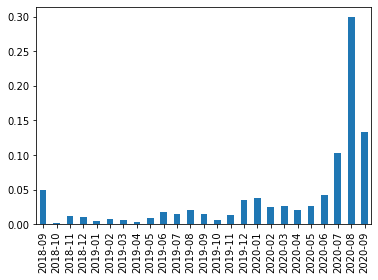

In [109]:
_ = test.merge(trends, left_on='article_id', right_index=True, how='left')
(_['min_dt'].dt.to_period('m').value_counts().sort_index() / _.shape[0]).plot.bar()

In [70]:
top_aug = test.merge(trends[trends['min_dt'].dt.to_period('m') == '2020-08'], left_on='article_id', right_index=True)['article_id'].value_counts()[:64]

In [76]:
test.merge(trends[trends['min_dt'].dt.to_period('m') == '2020-08'], left_on='article_id', right_index=True)

,t_dat,customer_id,article_id,price,sales_channel_id,min_dt,max_dt
31292784,2020-09-09,000fa1b80857fa40bf25990bc1b1b65afc63923a8e4b57...,0801673015,0.016932,2,2020-08-18,2020-09-08
31328611,2020-09-09,dc37c6cbcc6e6230c7cf6e53f6025172ed168fa4841fd2...,0801673015,0.016932,2,2020-08-18,2020-09-08
31328612,2020-09-09,dc37c6cbcc6e6230c7cf6e53f6025172ed168fa4841fd2...,0801673015,0.016932,2,2020-08-18,2020-09-08
31418104,2020-09-12,229f69ab6558103d75164bc68aa7556c43760cbe651b18...,0801673015,0.016458,2,2020-08-18,2020-09-08
31503919,2020-09-14,640ba48b073c0961ed38888e77e187bfa9eea014b86a20...,0801673015,0.016525,2,2020-08-18,2020-09-08
...,...,...,...,...,...,...,...
31542456,2020-09-15,c9f9e46123ccb240420cdb41e4fd24acafca2bcf487ca2...,0901818003,0.041475,2,2020-08-18,2020-09-06
31545279,2020-09-15,e49abe94619d2e322f6ffd4900dd743db405a6f691680c...,0808445003,0.025407,2,2020-08-12,2020-08-27
31545922,2020-09-15,eb7154cc517b5201ac64182c3767b7405ac948e8695bfa...,0901818001,0.042356,2,2020-08-24,2020-09-08
31546346,2020-09-15,ef9138f275aaf5e13c94d1605a13de318b731e66a2843d...,0872782001,0.042356,1,2020-08-26,2020-09-07


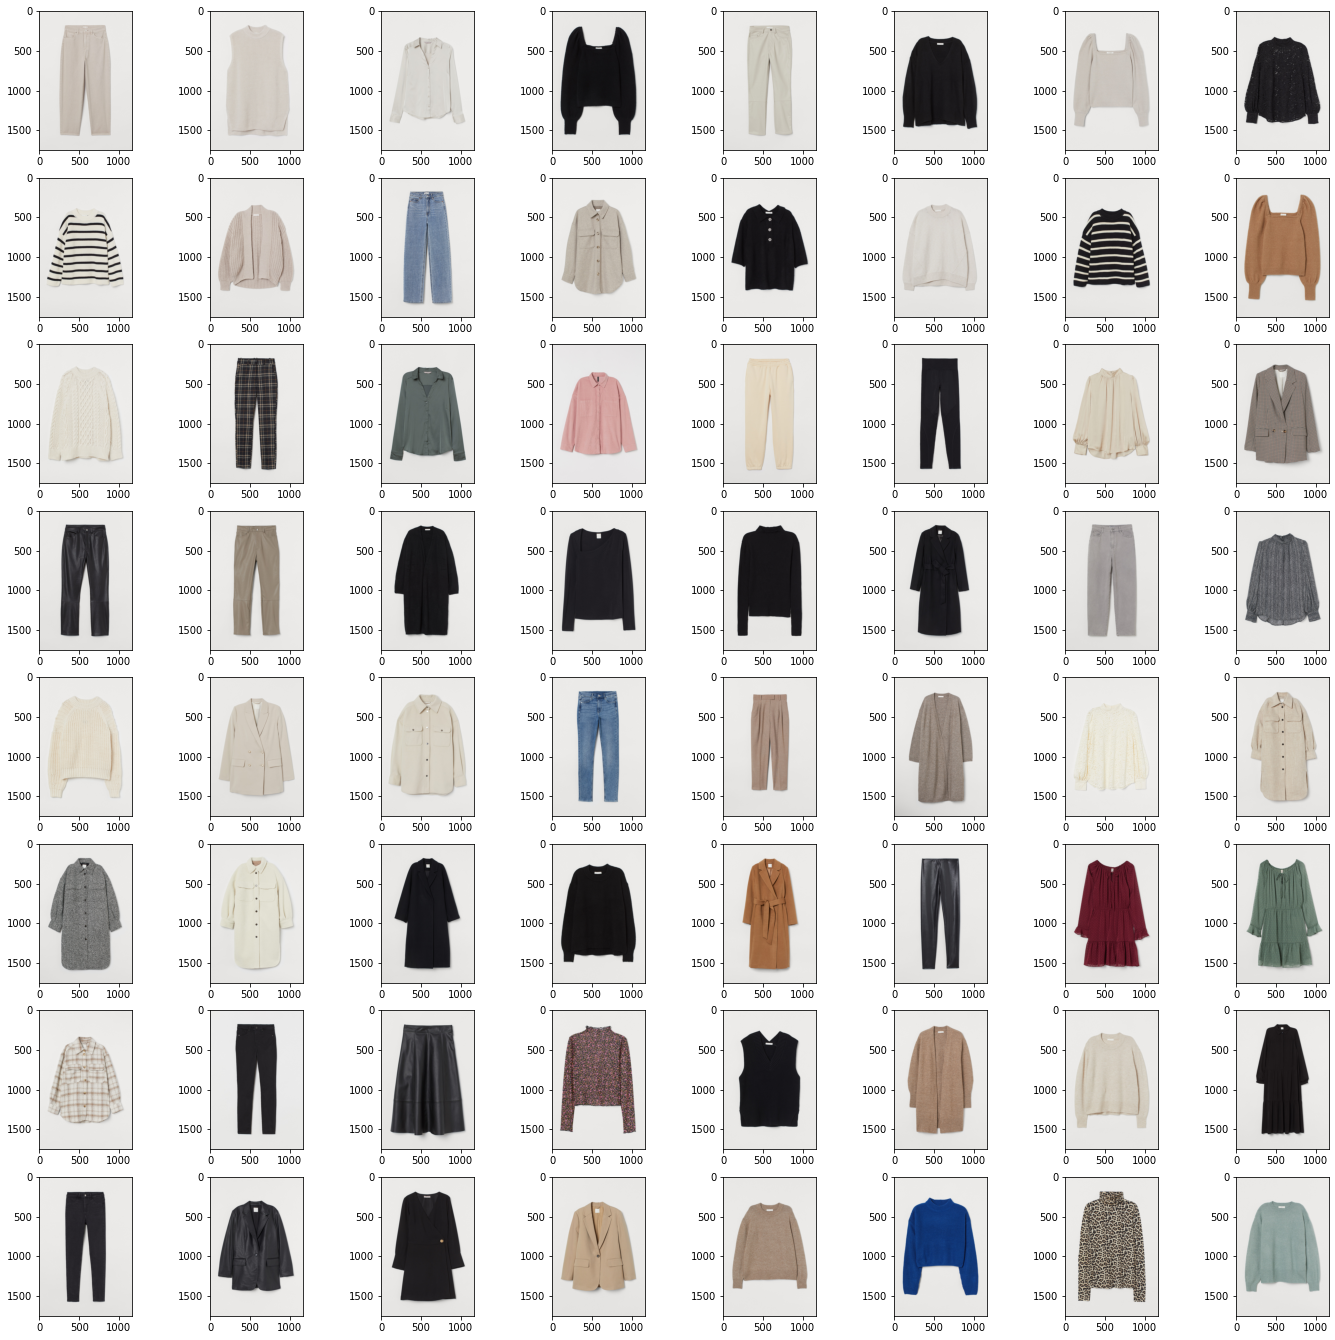

In [73]:
visualize_items(top_aug.index)

<AxesSubplot:>

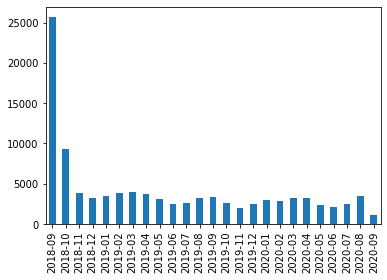

In [15]:
test.groupby('article_id')['customer_id'].count().reset_index().merge(trends, left_on='article_id', right_index=True, how='left')['min_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

In [121]:
results_ext = enrich_data(train, results, c)

In [123]:
results_ext.shape

(30785, 34)

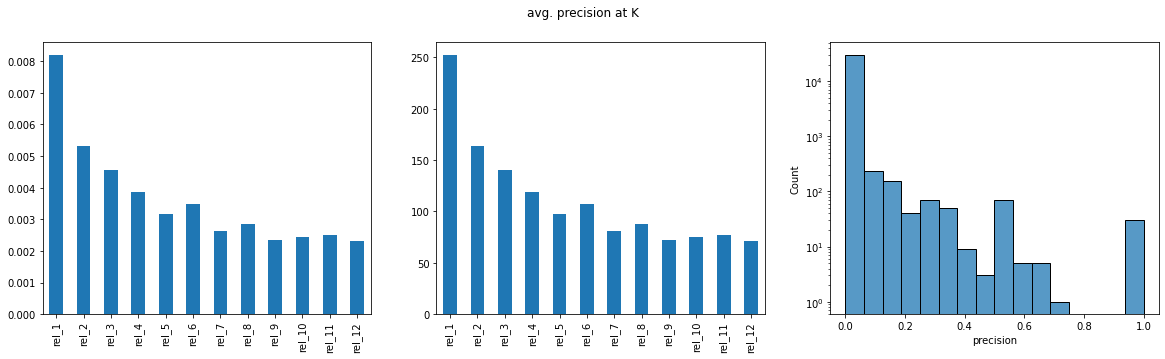

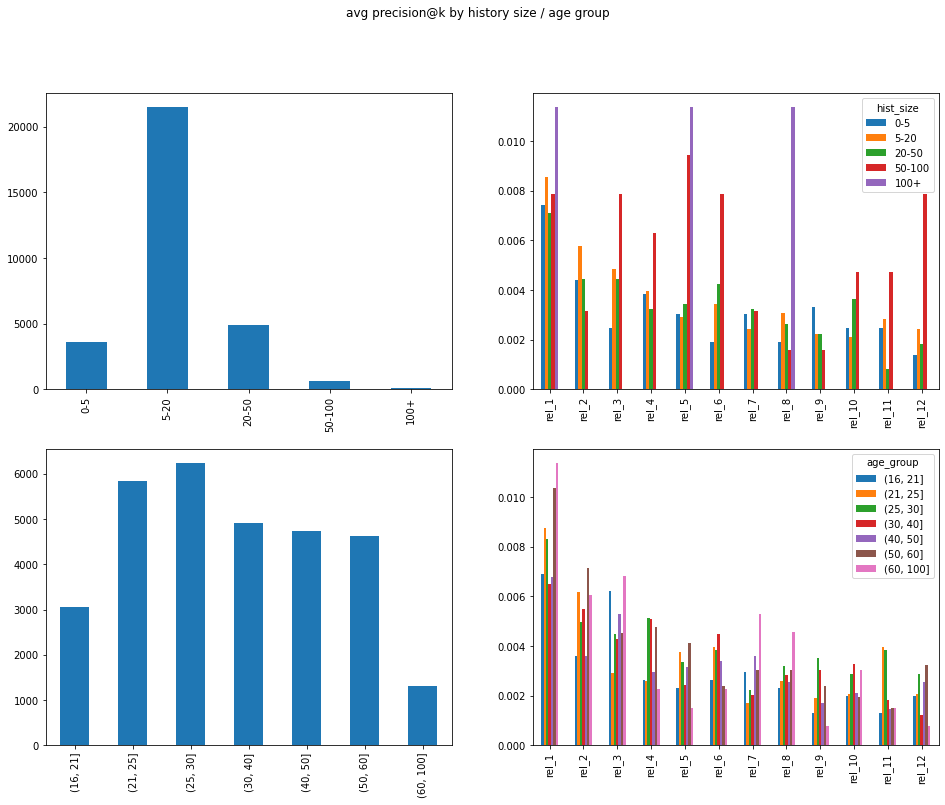

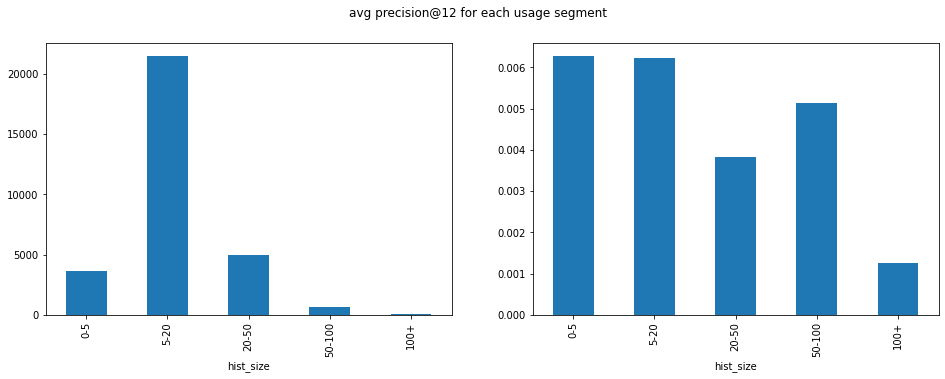

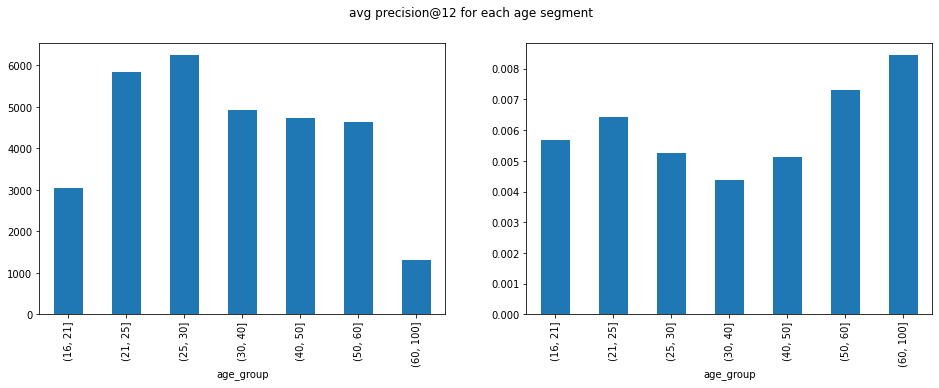

In [122]:
_ = results_ext.query('len_bought <= 12').pivot_table(
    index='len_bought',
    columns='rel_total',
    values='items_uniq',
    aggfunc='count'
).fillna(0).astype('int')

_ = plot_precision_at_k(results_ext)
_.show()

_ = plot_precision_at_k_segments(results_ext)
_.show()

_ = precision_by_usage(results_ext)
_.show()

_ = precision_by_age(results_ext)
_.show()

In [51]:
submission = pd.read_csv('sample_submission.csv.zip')

In [52]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


- do we use all users or users that have >= X items (potential speed-up)
- do we produce recs for all users or only for users with >= X items 
- RAND/GRID search factors / iterations / regularization 

In [102]:
mask = submission['customer_id'].apply(lambda _: _ in user_index)

In [103]:
ids = submission[mask]['customer_id'].apply(lambda _: user_index[_])

In [106]:
! date

Fri Apr  8 15:15:12 CEST 2022


In [127]:
id_sample = ids

In [128]:
items, scores = model.recommend(id_sample, X[id_sample], N=30, filter_already_liked_items=True, recalculate_user=False)

In [147]:
submission['cand'] = x
submission.loc[mask, 'cand'] = (
    pd
    .DataFrame(items[:, :12])
    .apply(lambda _: ' '.join([f"0{inv_item_index[item]}" for item in _]), axis=1)
)

In [162]:
submission.head()

,customer_id,prediction,backup,cand
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0618800001 0795440003 0615141002 0469137001 06...,0618800001 0795440003 0615141002 0469137001 06...,0618800001 0795440003 0615141002 0469137001 06...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0776237020 0599580052 0599580041 0609719001 07...,0776237020 0599580052 0599580041 0609719001 07...,0776237020 0599580052 0599580041 0609719001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0609719001 0458543001 0838055001 0351484027 04...,0609719001 0458543001 0838055001 0351484027 04...,0609719001 0458543001 0838055001 0351484027 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0730683001 0564786001 0720125007 0757303012 07...,0730683001 0564786001 0720125007 0757303012 07...,0730683001 0564786001 0720125007 0757303012 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0791587001 0629758005 0727948001 0720125007 08...,0791587001 0629758005 0727948001 0720125007 08...,0791587001 0629758005 0727948001 0720125007 08...


In [150]:
submission['prediction'] = submission['cand']

In [75]:
top_items = (
    df
    .groupby('article_id')
    .agg(
        cnt=('customer_id', 'count')
    )
    .reset_index()
    .sort_values('cnt', ascending=False)
)

In [78]:
naibe_pred = top_items.head(12)['article_id'].tolist()

In [82]:
x = ' '.join(map(str, naibe_pred))

In [83]:
submission['backup'] = submission['prediction']

In [84]:
submission.loc[submission['prediction'] == '', 'prediction'] = x

In [152]:
submission.shape

(1371980, 4)

In [151]:
submission[['customer_id', 'prediction']].to_csv('submission.csv', index=False)

In [ ]:
from kaggle_hm.config import 